<a href="https://colab.research.google.com/github/Santiago8888/Kin/blob/master/Intro_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"dzetaa","key":"00431f0f6a6a7725bdbe7b053b8ce916"}


In [0]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

In [0]:
!unzip \*.zip
! mkdir training
! mkdir testing

In [0]:
!mkdir training/cats
!mkdir training/dogs

!mkdir testing/cats
!mkdir testing/dogs

In [10]:
import os
cat_counter = 0
dog_counter = 0
for file in os.listdir('train'):
  if 'cat' in file:
    if cat_counter < 11250:
      os.rename('train/' + file, 'training/cats/' + file)
      cat_counter += 1
    else:
      os.rename('train/' + file, 'testing/cats/' + file)
  elif 'dog' in file:
    if dog_counter < 11250:
      os.rename('train/' + file, 'training/dogs/' + file)
      dog_counter +=1
    else:
      os.rename('train/' + file, 'testing/dogs/' + file)
print(cat_counter, dog_counter)

11250 11250


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
# TODO: Define image transforms for the training data and testing data.
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# Pass transforms in here.
train_data = datasets.ImageFolder('training', transform=train_transforms)
test_data = datasets.ImageFolder('testing', transform=test_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [0]:
model = models.densenet121(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model.to('cuda')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [20]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to cuda (GPU).
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to('cuda'), labels.to('cuda')
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Step: {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Step: 5.. Train loss: 0.531.. Test loss: 0.226.. Test accuracy: 0.959
Step: 10.. Train loss: 0.348.. Test loss: 0.208.. Test accuracy: 0.914
Step: 15.. Train loss: 0.271.. Test loss: 0.136.. Test accuracy: 0.953
Step: 20.. Train loss: 0.232.. Test loss: 0.083.. Test accuracy: 0.976
Step: 25.. Train loss: 0.193.. Test loss: 0.073.. Test accuracy: 0.977
Step: 30.. Train loss: 0.172.. Test loss: 0.065.. Test accuracy: 0.977
Step: 35.. Train loss: 0.156.. Test loss: 0.061.. Test accuracy: 0.976
Step: 40.. Train loss: 0.176.. Test loss: 0.087.. Test accuracy: 0.964
Step: 45.. Train loss: 0.204.. Test loss: 0.062.. Test accuracy: 0.980
Step: 50.. Train loss: 0.189.. Test loss: 0.057.. Test accuracy: 0.982
Step: 55.. Train loss: 0.157.. Test loss: 0.070.. Test accuracy: 0.972
Step: 60.. Train loss: 0.176.. Test loss: 0.086.. Test accuracy: 0.964
Step: 65.. Train loss: 0.272.. Test loss: 0.069.. Test accuracy: 0.973
Step: 70.. Train loss: 0.171.. Test loss: 0.164.. Test accuracy: 0.931
Step: 7

In [49]:
from PIL import Image

def image_transform(imagepath):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    image = Image.open(imagepath)
    imagetensor = test_transforms(image)
    return imagetensor
def predict(imagepath, verbose=False):
    model.eval()
    image = image_transform(imagepath)
    image1 = image[None,:,:,:]
    image1 = image1.to('cuda')
    ps=torch.exp(model(image1))
    topconf, topclass = ps.topk(1, dim=1)
    if topclass.item() == 1:
        return {'class':'dog','confidence':str(topconf.item())}
    else:
        return {'class':'cat','confidence':str(topconf.item())}
predict('test/10000.jpg')

{'class': 'dog', 'confidence': '0.9990796446800232'}

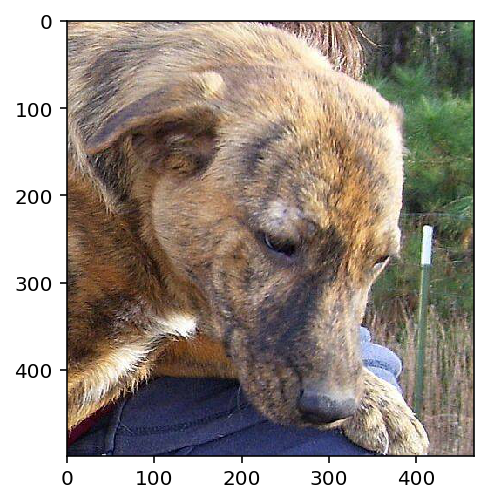

In [50]:
import matplotlib.image as mpimg
imgplot = plt.imshow(mpimg.imread('test/10000.jpg'))
